In [4]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_29172/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (including quality)
cols_2_zscore = data.keys()
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

# Convert from pandas dataframe to tensor

# But first drop residual sugar
cols_2_zscore = cols_2_zscore.drop('residual sugar')

dataT = torch.tensor( data[cols_2_zscore].values ).float()
sugar = torch.tensor( data['residual sugar'].values ).float()
sugar = sugar[:, None] # Transform to matrix

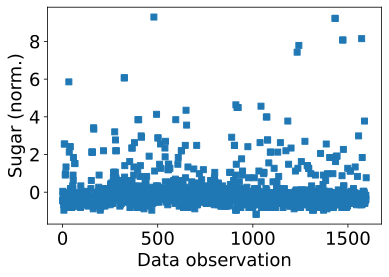

In [6]:
# Check values in sugar
plt.plot(sugar, 's')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [7]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data_SK, test_data_SK, train_labels_SK, test_labels_SK = train_test_split(dataT, sugar, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data_SK, train_labels_SK)
test_dataset  = TensorDataset(test_data_SK, test_labels_SK)

# Finally, translate into dataloader objects
train_batch_size = 32
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset, batch_size=test_batch_size)

# Now for the DL part

In [8]:
class ANN_wine(nn.Module):
  def __init__(self):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # Output layer
    self.output = nn.Linear(32, 1)
  
  # Forward pass
  def forward(self, x):
    x = F.relu(input=self.input(x))
    x = F.relu(input=self.fc1(x))
    x = F.relu(input=self.fc2(x))
    x = self.output(x)

    return x

# Train the model

In [9]:
# Global parameter
num_epochs = 1000

def train_the_model():
  """
  Create model included
  """
  # Continuous value
  loss_func = nn.MSELoss()
  optimizer = torch.optim.SGD(wine_net.parameters(), lr=0.01)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []

  # initialize losses
  train_loss = torch.zeros(num_epochs)
  test_loss  = torch.zeros(num_epochs)


  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    wine_net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = wine_net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    train_loss[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    wine_net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      pred_labels = wine_net(X)

    # .item(): Seperate out individual number from a PTorch obj
    test_loss[epoch_i] = loss_func(pred_labels, y).item()
    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_loss, test_loss

In [10]:
# Create a model and train it
wine_net              = ANN_wine()
train_loss, test_loss = train_the_model()

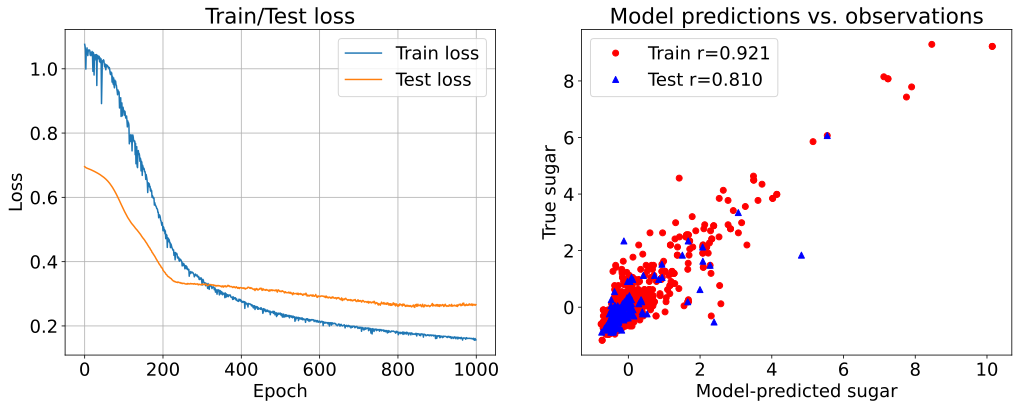

In [11]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(train_loss, label='Train loss')
ax[0].plot(test_loss, label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# Show predictions and real values
y_hat_train = wine_net(train_data_SK)
y_hat_test  = wine_net(test_data_SK)

# detach(): Output of the model is the Pytorch object having some numbers
ax[1].plot(y_hat_train.detach(), train_labels_SK, 'ro')
ax[1].plot(y_hat_test.detach(),  test_labels_SK,  'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# Correlations between predictions and outputs
corr_train = np.corrcoef(y_hat_train.detach().T, train_labels_SK.T)[1,0]
corr_test  = np.corrcoef(y_hat_test.detach().T,  test_labels_SK.T)[1,0]
ax[1].legend([f'Train r={corr_train:.3f}',f'Test r={corr_test:.3f}'])

plt.show()

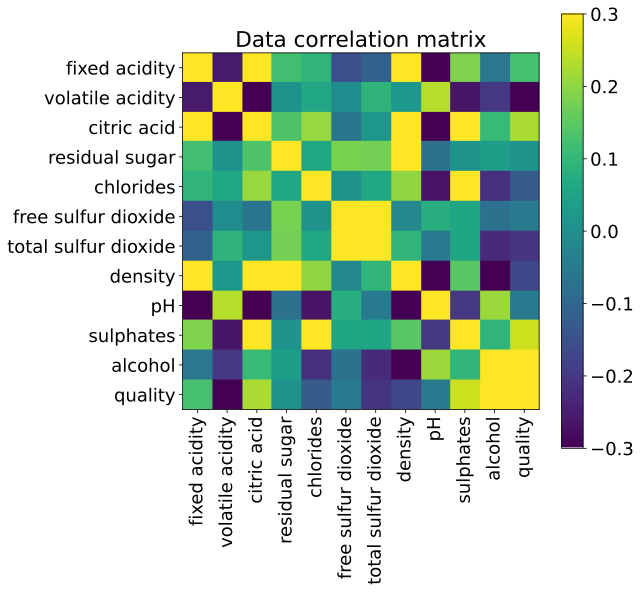

In [12]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)

plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

# Additional explorations

In [ ]:
# 1) Why did the output node not have a sigmoid activation function? It is possible to train this model using a sigmoid
#    function on the output?
# 
# 2) Let's say you don't need to know the *exact* sugar amount, only the approximate amount. You could then label each
#    wine as being in one of three bins, according to the amount of sugar. What would you need to change in the model?
# 